# STAT207 Mini-Project #1 - Game Revenue Analysis


## Vedaant Agarwal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Introduction

### 1.1 Primary Research Goal

The main research goal of this project is to study the association between the gross sales of a game and the median amount of time taken to complete the game based on which publisher made the game.

### 1.2 Research Motivation

Suppose you are working at a game marketplace like Steam and would like to analyze which games from a publisher would generate the most amount of revenue based on primarily the median time a player takes to complete a game. This would help Steam select the games from a publisher that provide them with the most revenue. This study could also be built upon by adding additional parameters like is the game cross platform, does it have online features, etc.

This also helps the publishers decide whether to make longer or shorter games, and which might generate more revenue based on past trends.

## 2. Dataset Discussion

Originally collected by Dr. Joe Cox, this dataset has information about the sales and playtime of over a thousand video games released between 2004 and 2010. The playtime information was collected from crowd-sourced data on “How Long to Beat”. Some more information can be found on: https://researchportal.port.ac.uk/en/publications/what-makes-a-blockbuster-video-game-an-empirical-analysis-of-us-s

The dataset was downloaded on 9/8/2023 from: https://corgis-edu.github.io/corgis/csv/video_games/

## 3. Dataset Cleaning

### 3.1 Data Import

In [2]:
df = pd.read_csv('video_games.csv')
df.head()

,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,...,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,...,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


### 3.2 Selecting the Columns to Study

We want to study the association between `Metrics.Sales` and `Length.All PlayStyles.Median` for different levels of `Metadata.Publishers`. Let us select only these columns. We do not drop any `NA` values yet so as to preserve as many rows as we can.

In [3]:
df_filter = df[['Metrics.Sales', 'Length.All PlayStyles.Median', 'Metadata.Publishers']]
df_filter.head()

,Metrics.Sales,Length.All PlayStyles.Median,Metadata.Publishers
0,4.69,24.483333,Nintendo
1,0.56,10.000000,Ubisoft
2,0.54,2.500000,Nintendo
3,0.49,0.000000,Sony
4,0.45,10.000000,Activision


### 3.3 Implicit Missing Values and NA Removal

Let us check for the datatypes of the columns in our filtered dataframe. We expect `Metrics.Sales` and `Length.All PlayStyles.Median` to be numerical columns, and `Metadata.Publishers` to be a categorical column. So, the pandas series for `Metrics.Sales` and `Length.All PlayStyles.Median` should be of type `float64` and `Metadata.Publishers` should be of type `object`.

In [4]:
df_filter.dtypes

Metrics.Sales                   float64
Length.All PlayStyles.Median    float64
Metadata.Publishers              object
dtype: object

This shows that there might not be any implicit missing values in the filtered dataframe. The `Metadata.Publishers` will be checked to see if there is some phrase that represents a missing value.

In [5]:
df_filter['Metadata.Publishers'].unique()

array(['Nintendo', 'Ubisoft', 'Sony', 'Activision', 'EA', 'Namco',
       'Konami', nan, 'Sega', 'Capcom', 'Capcom,Rockstar',
       'Activision,Konami', 'Rockstar', 'THQ', 'Microsoft',
       'Activision,Sony', '2K', 'Atari', 'SquareEnix', 'EA,Namco',
       'Namco,Sony', 'Midway', 'Eidos', 'Sony,Ubisoft',
       'Nintendo,SquareEnix', 'EA,Sony', 'Microsoft,SquareEnix',
       'Atari,Namco', 'Nintendo,Sega', 'Capcom,Nintendo', 'Disney',
       'Namco,Ubisoft'], dtype=object)

All of these readings represent an actual game publisher, so there is no implicit missing value in the filtered dataframe. A check to see if there are any `NA` values is done below.

In [6]:
df_filter.isna().sum()

Metrics.Sales                     0
Length.All PlayStyles.Median      0
Metadata.Publishers             264
dtype: int64

Since the `NA` values are all for `Metadata.Publishers` it does not make sense to replace them with a common grouped publisher, as it does not provide any insights for the actual publishers of the games. So, these values will be dropped.

In [7]:
df_drop_na = df_filter.dropna()

### 3.4 Outlier Removal

Let us take a look at the boxplots for `Metrics.Sales` and `Length.All PlayStyles.Median` to check for any outliers that might greatly affect results.

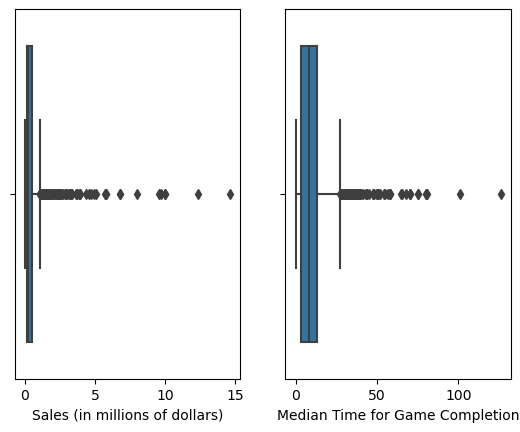

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.boxplot(x=df_drop_na['Metrics.Sales'], ax=ax1)
sns.boxplot(x=df_drop_na['Length.All PlayStyles.Median'], ax=ax2)
ax1.set_xlabel('Sales (in millions of dollars)')
ax2.set_xlabel('Median Time for Game Completion')
plt.show()

So we see that both of them have a lot of high outliers. Let us limit our study to `Metrics.Sales` $< 4$ and `Length.All PlayStyles.Median` $< 50$. These are arbitrary values that I have selected that still keep a good amount of outliers, while removing the extreme outliers.

In [9]:
df_rm_out = df_drop_na[(df_drop_na['Metrics.Sales'] < 4) & (df_drop_na['Length.All PlayStyles.Median'] < 50)]

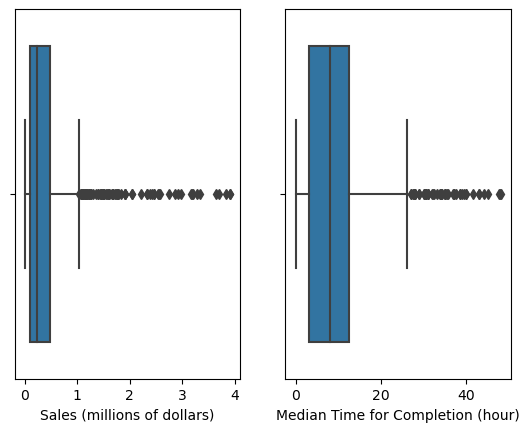

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.boxplot(x=df_rm_out['Metrics.Sales'], ax=ax1)
sns.boxplot(x=df_rm_out['Length.All PlayStyles.Median'], ax=ax2)
ax1.set_xlabel('Sales (millions of dollars)')
ax2.set_xlabel('Median Time for Completion (hour)')
plt.show()

The visuliztions look a lot better and the range where the bulk of the data resides is now comparable to the maximum remaining values so they would not severely affect the results.

### 3.5 Selecting Only the Top Publishers

Let us take a look at how many publishers there are in the dataset, and how many games they have produced.

In [11]:
publishers = df_rm_out['Metadata.Publishers'].value_counts()
publishers

EA                      165
Ubisoft                  91
Activision               85
Sega                     75
Nintendo                 68
THQ                      61
Sony                     60
2K                       48
Konami                   43
Capcom                   33
Namco                    29
SquareEnix               27
Midway                   23
Eidos                    22
Atari                    20
Microsoft                16
Rockstar                 11
Disney                   10
Atari,Namco               4
Nintendo,Sega             2
Sony,Ubisoft              2
Namco,Sony                2
EA,Namco                  2
Capcom,Rockstar           1
Nintendo,SquareEnix       1
EA,Sony                   1
Microsoft,SquareEnix      1
Activision,Sony           1
Capcom,Nintendo           1
Activision,Konami         1
Namco,Ubisoft             1
Name: Metadata.Publishers, dtype: int64

For the sake of clarity, let us only select publishers that have 60 or more games published (that does not include any games we considered outliers). Note that while this would make it not representative of all games, but for any particular publisher, it does not affect the association between the sales and the median time taken to complete the game.

In [12]:
more_than_59 = publishers.index[publishers >= 60]
df_final = df_rm_out[df_rm_out['Metadata.Publishers'].isin(more_than_59)]
df_final['Metadata.Publishers'].value_counts()

EA            165
Ubisoft        91
Activision     85
Sega           75
Nintendo       68
THQ            61
Sony           60
Name: Metadata.Publishers, dtype: int64

## 4. <u>Research Question</u>: How does the Relationship between `x` and `y` Change based on Different Values of `z` in the Dataset?

Let us look at the correlation between `Metrics.Sales` and `Length.All PlayStyles.Median` for the various publishers.

In [13]:
df_final.groupby('Metadata.Publishers').corr()

Metrics.Sales  \
Metadata.Publishers                                               
Activision          Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.116106   
EA                  Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.216140   
Nintendo            Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.295784   
Sega                Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median      -0.046409   
Sony                Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.083568   
THQ                 Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.469453   
Ubisoft             Metrics.Sales                      1.000000   
                    Length.All PlayStyles.Median       0.071311   

                                                  Length.All PlayStyles.Median  
Metadata.Publishers                                                             
Activision          Metrics.Sales                                     0.116106  
                    Length.All PlayStyles.Median                      1.000000  
EA                  Metrics.Sales                                     0.216140  
                    Length.All PlayStyles.Median                      1.000000  
Nintendo            Metrics.Sales                                     0.295784  
                    Length.All PlayStyles.Median                      1.000000  
Sega                Metrics.Sales                                    -0.046409  
                    Length.All PlayStyles.Median                      1.000000  
Sony                Metrics.Sales                                     0.083568  
                    Length.All PlayStyles.Median                      1.000000  
THQ                 Metrics.Sales                                     0.469453  
                    Length.All PlayStyles.Median                      1.000000  
Ubisoft             Metrics.Sales                                     0.071311  
                    Length.All PlayStyles.Median                      1.000000

We see that for all publishers except Sega, the sign of the association is positive. This means that, on average, we expect the revenue for Sega games to decrease for the longer the games they make. We also see that THQ has the highest strength of the association.

Let us now take a look at the scatterplot for sales and median game completion time, colour coded with the publishers, and with a best fit line included.

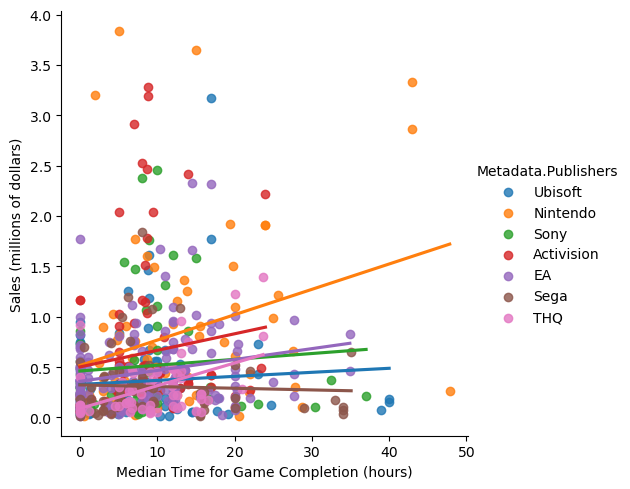

In [14]:
sns.lmplot(x='Length.All PlayStyles.Median', y='Metrics.Sales', hue='Metadata.Publishers', ci= False,
          data=df_final)
plt.ylabel('Sales (millions of dollars)')
plt.xlabel('Median Time for Game Completion (hours)')
plt.show()

Let us look at each publisher individually, for ease of viewing.

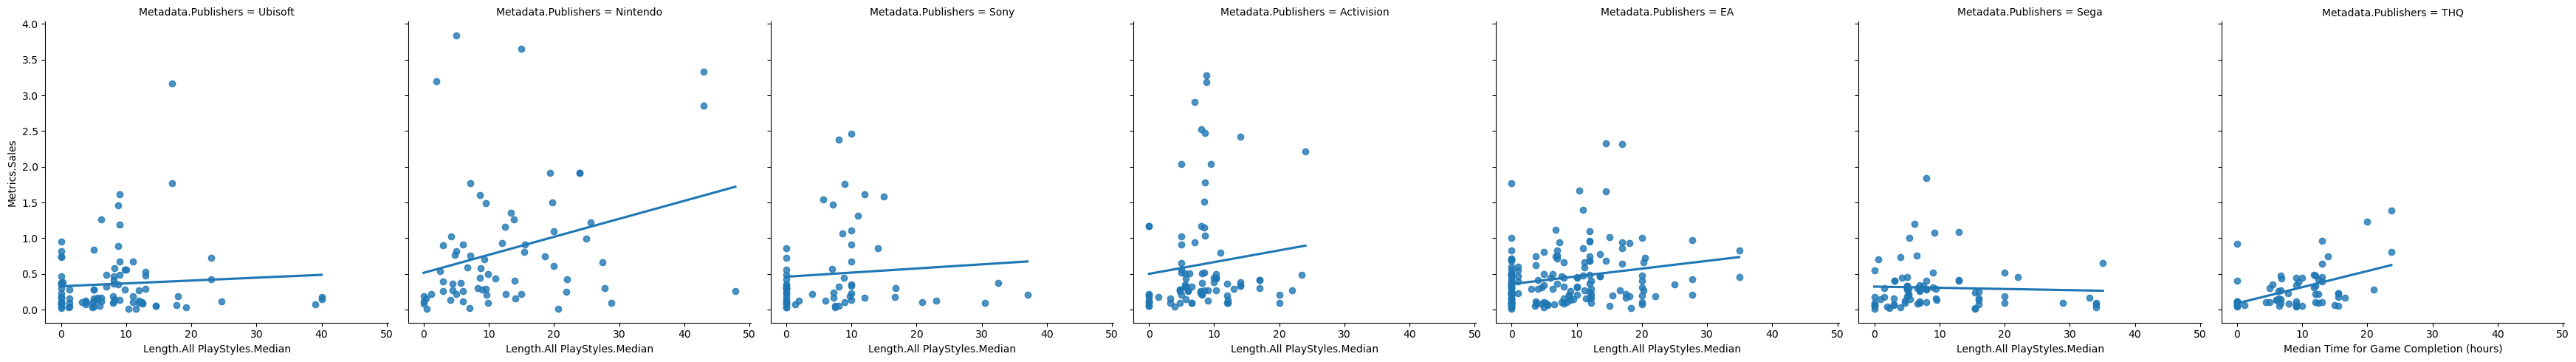

In [15]:
sns.lmplot(x='Length.All PlayStyles.Median', y='Metrics.Sales', col='Metadata.Publishers', ci= False,
          data=df_final)
plt.ylabel('Sales (in millions of dollars)')
plt.xlabel('Median Time for Game Completion (hours)')
plt.show()

We see that the slopes of the best fit lines are different for different publishers. This implies that there is some interaction between the publishers and the median completion time in their effect on the gross sales. So, if a linear regression model is done, the variables publishers and median completion time would not be independent, and an interaction term would have to be included.

Other than that, we see that Nintendo has the steepest slope for this graph, and Sega has a negative slope. This has interesting implications for these companies.

## 5. Conclusion

We see that the publisher does have an effect on the association between gross sales and median completion time. 

So, if I am working at Steam, I would say based off of this result that Steam should get longer Nintendo games and shorter Sega games. For the other publishers as well, longer games are better on average, but the payoff for getting longer Nintendo games is higher on average.